In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
customers = pd.read_csv('customers.csv')
transactions = pd.read_csv('Transactions.csv')


In [3]:
data = pd.merge(transactions, customers, on='CustomerID', how='inner')


In [5]:
aggregated_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count'
}).rename(columns={
    'TotalValue': 'TotalSpent',
    'Quantity': 'TotalQuantity',
    'TransactionID': 'TransactionCount'
})


In [6]:
customer_features = pd.merge(aggregated_data, customers, on='CustomerID', how='left')


In [7]:
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)


In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1))


In [9]:
#Apply K-Means Clustering:
#Choose a number of clusters (e.g., between 2 and 10) and fit the K-Means model.
kmeans = KMeans(n_clusters=5, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

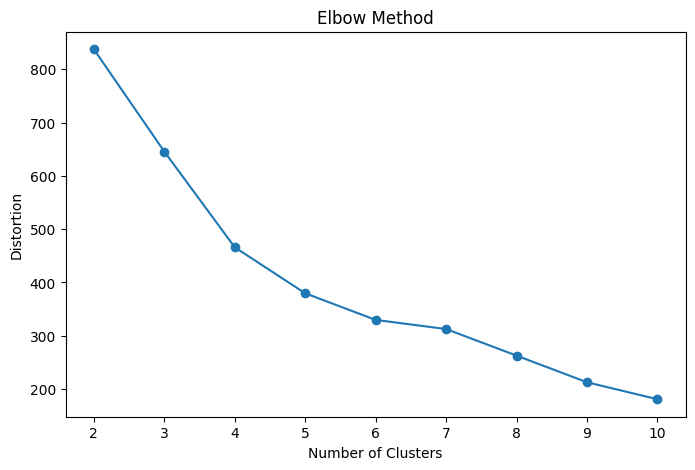

In [10]:
distortions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()


In [11]:
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.9384521529981805


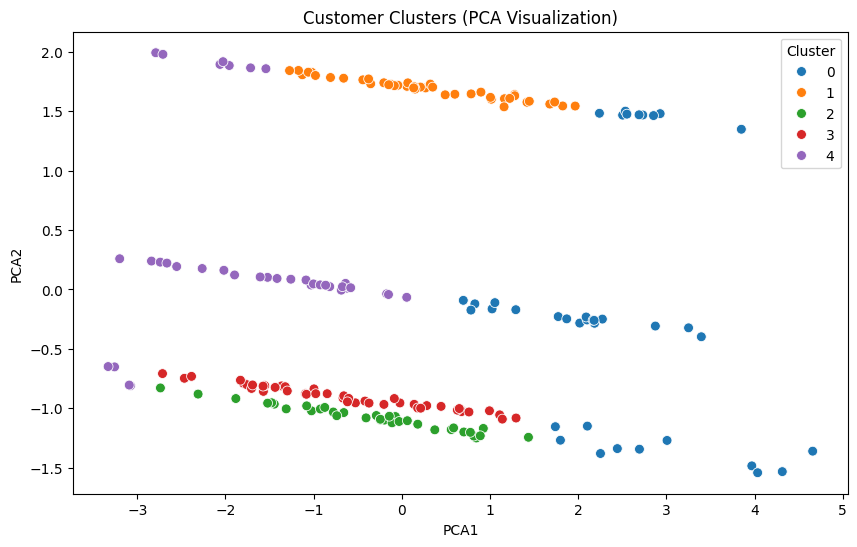

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
customer_features['PCA1'] = reduced_features[:, 0]
customer_features['PCA2'] = reduced_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_features,
    x='PCA1', y='PCA2',
    hue='Cluster', palette='tab10', s=50
)
plt.title('Customer Clusters (PCA Visualization)')
plt.show()


In [14]:
print(customer_features.dtypes)



CustomerID               object
TotalSpent              float64
TotalQuantity             int64
TransactionCount          int64
CustomerName             object
SignupDate               object
Region_Europe              bool
Region_North America       bool
Region_South America       bool
Cluster                   int32
PCA1                    float64
PCA2                    float64
dtype: object


In [15]:
numeric_features = customer_features.select_dtypes(include=["number"])


In [16]:
cluster_summary = numeric_features.groupby(customer_features['Cluster']).mean()
print(cluster_summary)


          TotalSpent  TotalQuantity  TransactionCount  Cluster      PCA1  \
Cluster                                                                    
0        5935.633421      21.710526          8.026316      0.0  2.414833   
1        3702.809048      13.071429          5.142857      1.0  0.304265   
2        2920.969730      11.378378          4.783784      2.0 -0.339857   
3        3146.072045      11.181818          4.500000      3.0 -0.600969   
4        1642.643684       6.578947          2.736842      4.0 -1.724354   

             PCA2  
Cluster            
0       -0.153185  
1        1.690037  
2       -1.078550  
3       -0.907484  
4        0.386187  


In [20]:
customer_features.to_csv('Customer_Segmentation.csv', index=False)


In [24]:
import pandas as pd
from sklearn.cluster import DBSCAN

# Assuming 'data' is your dataframe
numeric_data = data.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns

# Fit the DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(numeric_data)

# Get the cluster labels
labels = dbscan.labels_

# Count the number of unique clusters
number_of_clusters = len(np.unique(labels[labels != -1]))  # Excluding noise points (-1)

print("Number of clusters formed:", number_of_clusters)




Number of clusters formed: 53


In [26]:
# Assuming 'data' is your dataframe
data_numeric = data.select_dtypes(include=[np.number])  # Select only numeric columns


In [29]:
print(data.columns)


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')


In [34]:
label_cols = ['Category']  # Update this with the correct column name


In [36]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Step 1: Print all column names to check if 'Category' exists
print(data.columns)

# If 'Category' column exists, proceed with encoding
label_cols = ['CorrectColumnName']  # Replace with the correct column name

# Encode categorical columns
le = LabelEncoder()
for col in label_cols:
    if col in data.columns:
        data[col] = le.fit_transform(data[col])
    else:
        print(f"Column '{col}' does not exist.")

# Step 2: Scaling the data (for numeric columns only)
data_numeric = data.select_dtypes(include=[np.number])  # Only keep numeric columns
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Step 3: Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(data_scaled)

# Step 4: Calculate DB Index (Davies-Bouldin Index)
db_index = davies_bouldin_score(data_scaled, labels)

# Step 5: Calculate Silhouette Score (only valid for multiple clusters)
if len(np.unique(labels)) > 1:  # Ensure more than 1 cluster
    silhouette_avg = silhouette_score(data_scaled, labels)
else:
    silhouette_avg = 'N/A'  # Silhouette score cannot be calculated for a single cluster

# Output the clustering metrics
print("Davies-Bouldin Index (DB Index):", db_index)
print("Silhouette Score:", silhouette_avg)

# Exclude noise points (-1) for DBSCAN
num_clusters = len(np.unique(labels[labels != -1]))  # Exclude noise points
print("Number of Clusters:", num_clusters)


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')
Column 'CorrectColumnName' does not exist.
Davies-Bouldin Index (DB Index): 2.1803421071191345
Silhouette Score: 0.21241664189580534
Number of Clusters: 4


In [38]:
kmeans.inertia_


180.84734434049165